In [1]:
%load_ext autoreload
%autoreload 2
from matplotlib import pyplot as plt
%matplotlib inline

In [87]:
import numpy as np
import scanpy as sc
from util import normalize_rows, mse

from sklearn.utils.extmath import randomized_svd

# Concavity of sqrt

In [4]:
from scipy.special import factorial
def expected_sqrt(mean, samples=None):
    """Return expected square root of a poisson distribution. Expects ndarray input.
    
    If samples = None, uses Taylor series centered at 0 or mean, as appropriate.
    
    If samples = int, uses that many samples for an empirical distribution."""
    
    if samples is None:
    
        truncated_taylor_around_0 = np.zeros(mean.shape)
        nonzeros = (mean != 0)
        mean = mean + 1e-8
        small_values = mean*(mean < 4)
        for k in range(15):
            truncated_taylor_around_0 += small_values**k/factorial(k) * np.sqrt(k)
        truncated_taylor_around_0 *= np.exp(-small_values)

        truncated_taylor_around_mean = np.sqrt(mean) - np.sqrt(mean)**(-0.5)/8 + np.sqrt(mean)**(-1.5)/16

        expectation = nonzeros*(truncated_taylor_around_0 * (mean < 4) + truncated_taylor_around_mean * (mean >= 4))
        
    else:
        tot = np.zeros(mean.shape)
        for i in range(samples):
            tot += np.sqrt(np.random.poisson(mean))
        expectation = tot/samples
    return expectation

In [54]:
from scipy.special import factorial
def expected_log(mean, samples=None):
    """Return expected square root of a poisson distribution. Expects ndarray input.
    
    If samples = None, uses Taylor series centered at 0 or mean, as appropriate.
    
    If samples = int, uses that many samples for an empirical distribution."""
    
    if samples is None:
        raise NotImplementedError
    else:
        tot = np.zeros(mean.shape)
        for i in range(samples):
            tot += np.log1p(np.random.poisson(mean))
        expectation = tot/samples
    return expectation

In [19]:
mean = np.power(10.001, np.arange(-2, 2, 0.1))

In [20]:
e1 = expected_sqrt(mean)
e2 = expected_sqrt(mean, 1000)

In [21]:
np.corrcoef(e1.ravel(), e2.ravel())

array([[1.        , 0.99997817],
       [0.99997817, 1.        ]])

Text(0.5,1,'Sampling agrees with theory.')

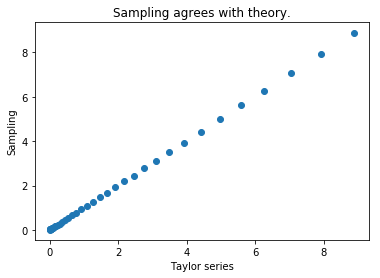

In [22]:
plt.scatter(e1, e2)
plt.xlabel("Taylor series")
plt.ylabel("Sampling")
plt.title("Sampling agrees with theory.")

Text(0.5,1,'Expectation is mean at low values')

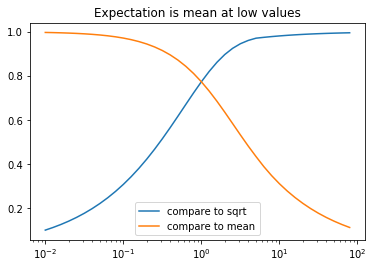

In [23]:
plt.plot(lam, expected_sqrt(lam)/np.sqrt(lam), label = 'compare to sqrt')
plt.plot(lam, expected_sqrt(lam)/lam, label = 'compare to mean')
plt.xscale('log')
plt.legend()
plt.title("Expectation is mean at low values")

# HCA

In [311]:
hca = sc.read('/Users/josh/src/noise2self-single-cell/data/hca/hca_marrow_deep.h5ad')
hca_down = sc.pp.downsample_counts(hca, 2000, replace = False, copy = True)

In [312]:
at_least_500 = np.array((hca.X.sum(axis = 0) > 500)).flatten()
at_least_0 = np.array((hca_down.X.sum(axis = 0) > 0)).flatten()

In [313]:
y = np.array(hca.X.todense())
x = np.array(hca_down.X.todense()).astype(np.int)

In [314]:
y = y[:, at_least_500 & at_least_0]
x = x[:, at_least_500 & at_least_0]

In [315]:
mean = y/y.sum(axis = 1, keepdims = True) * 1000

In [316]:
z = expected_sqrt(mean)

In [317]:
x1 = np.random.binomial(x, 0.5)
x2 = x - x1

In [318]:
x.shape, at_least_0.sum()

((1277, 6883), 13303)

## PCA: Square root

In [319]:
x1_norm = np.sqrt(x1)
x2_norm = np.sqrt(x2)

U, S, V = randomized_svd(x1_norm, n_components=50, random_state=42)

ae_loss = []
ss_loss = []
gt_loss = []
k_range = np.arange(1, 30)
for k in k_range:
    x_pred = U[:,:k].dot(np.diag(S[:k])).dot(V[:k,:])
    ae_loss.append(mse(x_pred, x1_norm))
    ss_loss.append(mse(x_pred, x2_norm))
    gt_loss.append(mse(x_pred, z))
k_opt = k_range[np.argmin(loss)]
                
print(k_opt)

6


Text(0.5,0,'Principal Components')

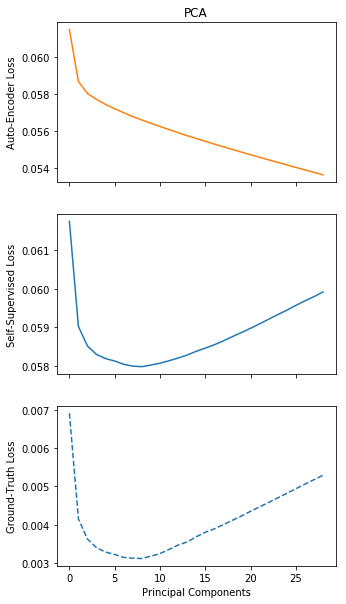

In [320]:
f, (ax0, ax1, ax2) = plt.subplots(3, 1, sharex=True, figsize=(5, 10))

ax0.plot(ae_loss, color = 'C1')
ax0.set_title("PCA")
ax0.set_ylabel('Auto-Encoder Loss')

ax1.plot(ss_loss)
ax1.set_ylabel('Self-Supervised Loss')
ax2.plot(gt_loss, '--')
ax2.set_ylabel('Ground-Truth Loss')
ax2.set_xlabel('Principal Components')

In [321]:
# Negative log likelihood
def poisson_log_lik(lam, k, per_gene = False):
    if per_gene:
        return (lam - k*np.log(lam)).mean(axis = 0)
    else:
        return (lam - k*np.log(lam)).mean()

In [322]:
ss_loss, gt_loss, ae_loss = [], [], []
for k in np.arange(1, 10):
    x_pred = U[:,:k].dot(np.diag(S[:k])).dot(V[:k,:])
    ae_loss.append(poisson_log_lik(x_pred**2 + 1e-3, x1))
    ss_loss.append(poisson_log_lik(x_pred**2 + 1e-3, x2))
    gt_loss.append(poisson_log_lik(x_pred**2 + 1e-3, mean))

Text(0.5,0,'Principal Components')

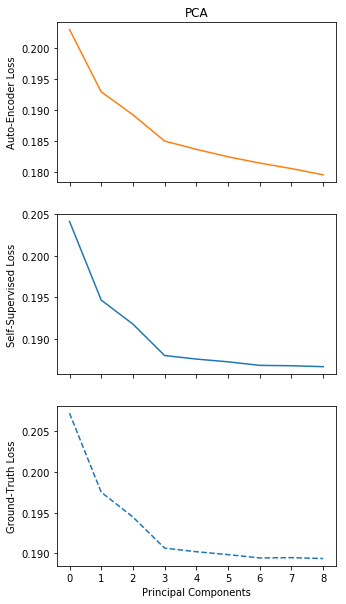

In [323]:
f, (ax0, ax1, ax2) = plt.subplots(3, 1, sharex=True, figsize=(5, 10))

ax0.plot(ae_loss, color = 'C1')
ax0.set_title("PCA")
ax0.set_ylabel('Auto-Encoder Loss')

ax1.plot(ss_loss)
ax1.set_ylabel('Self-Supervised Loss')
ax2.plot(gt_loss, '--')
ax2.set_ylabel('Ground-Truth Loss')
ax2.set_xlabel('Principal Components')

If we use MSE loss on the counts, then the noise variance = variance(Poisson(lambda)) = lambda, which is also the mean. Thus the noise variance can be approximated as just the average of the input data, which would allow us to estimate the ground-truth reconstruction error.

# MAGIC

In [324]:
import magic
max_t=20
lazy_p=1

median_counts = np.median(x1.sum(axis=1)) / 2

X1 = np.sqrt(normalize_rows(x1, median_counts))
X2 = np.sqrt(normalize_rows(x2, median_counts))

magic_op = magic.MAGIC()
magic_op.fit(X1)

diff_op = np.array(magic_op.diff_op.todense())

#diff_op = lazy_p * diff_op + (1 - lazy_p) * np.eye(diff_op.shape[0])

Running MAGIC on 1277 cells and 6883 genes.
Calculating graph and diffusion operator...
  Calculating PCA...
  Calculated PCA in 1.05 seconds.
  Calculating KNN search...
  Calculated KNN search in 0.28 seconds.
  Calculating affinities...
  Calculated affinities in 0.53 seconds.
Calculated graph and diffusion operator in 1.92 seconds.


In [325]:
denoised = np.sqrt(x1)

ss_loss, gt_loss, ae_loss = [], [], []

max_t = 7

for i in range(max_t):
    # denoised/denoised.sum(axis = 1, keepdims = True) * x2.sum(axis = 1, keepdims = True)
    ss_loss.append(mse(denoised, np.sqrt(x2)))
    ae_loss.append(mse(denoised, np.sqrt(x1)))
    gt_loss.append(mse(denoised, z))

    denoised = diff_op.dot(denoised)

Text(0.5,0,'Principal Components')

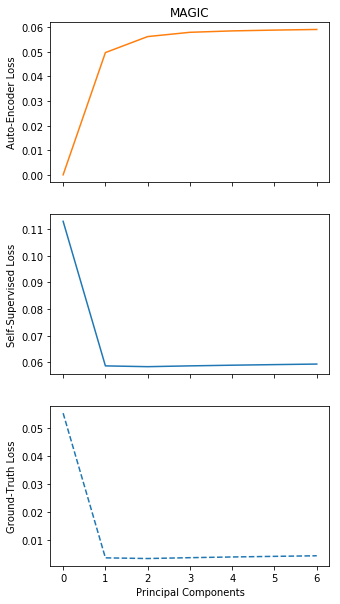

In [326]:
f, (ax0, ax1, ax2) = plt.subplots(3, 1, sharex=True, figsize=(5, 10))

ax0.plot(ae_loss, color = 'C1')
ax0.set_title("MAGIC")
ax0.set_ylabel('Auto-Encoder Loss')

ax1.plot(ss_loss)
ax1.set_ylabel('Self-Supervised Loss')
ax2.plot(gt_loss, '--')
ax2.set_ylabel('Ground-Truth Loss')
ax2.set_xlabel('Principal Components')

MAGIC is too fast with initial parameters. We slow it down by making the walk lazy.

Running MAGIC on 1277 cells and 6883 genes.
Calculating graph and diffusion operator...
  Calculating PCA...
  Calculated PCA in 1.17 seconds.
  Calculating KNN search...
  Calculated KNN search in 0.34 seconds.
  Calculating affinities...
  Calculated affinities in 0.67 seconds.
Calculated graph and diffusion operator in 2.25 seconds.


Text(0.5,0,'Diffusion Time')

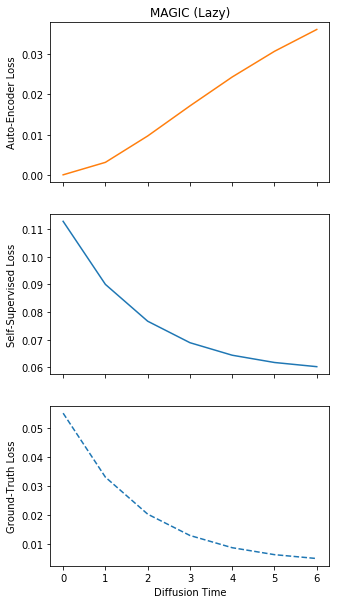

In [327]:
import magic
max_t=7
lazy_p=0.25

median_counts = np.median(x1.sum(axis=1)) / 2

X1 = np.sqrt(normalize_rows(x1, median_counts))
X2 = np.sqrt(normalize_rows(x2, median_counts))

magic_op = magic.MAGIC()
magic_op.fit(X1)

diff_op = np.array(magic_op.diff_op.todense())

diff_op = lazy_p * diff_op + (1 - lazy_p) * np.eye(diff_op.shape[0])

denoised = np.sqrt(x1)

ss_loss, gt_loss, ae_loss = [], [], []

for i in range(max_t):
    # denoised/denoised.sum(axis = 1, keepdims = True) * x2.sum(axis = 1, keepdims = True)
    ss_loss.append(mse(denoised, np.sqrt(x2)))
    ae_loss.append(mse(denoised, np.sqrt(x1)))
    gt_loss.append(mse(denoised, z))

    denoised = diff_op.dot(denoised)
    
f, (ax0, ax1, ax2) = plt.subplots(3, 1, sharex=True, figsize=(5, 10))

ax0.plot(ae_loss, color = 'C1')
ax0.set_title("MAGIC (Lazy)")
ax0.set_ylabel('Auto-Encoder Loss')

ax1.plot(ss_loss)
ax1.set_ylabel('Self-Supervised Loss')
ax2.plot(gt_loss, '--')
ax2.set_ylabel('Ground-Truth Loss')
ax2.set_xlabel('Diffusion Time')

In [328]:
print("Min GT Loss: ", np.min(gt_loss))

Min GT Loss:  0.004825353656198806


We can also use a Poisson loss on averaged counts.

## Poisson

In [329]:
denoised = x1.copy()

ss_loss, gt_loss, ae_loss = [], [], []

for i in range(max_t):    
    ae_loss.append(poisson_log_lik(denoised + 1e-3, x1))
    ss_loss.append(poisson_log_lik(denoised + 1e-3, x2))
    gt_loss.append(poisson_log_lik(denoised + 1e-3, mean))

    denoised = diff_op.dot(denoised)

Text(0.5,0,'Diffusion Time')

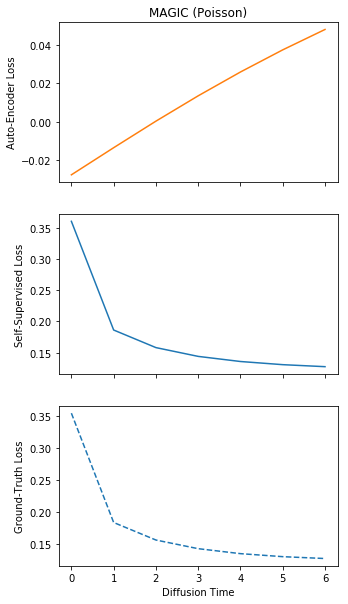

In [330]:
f, (ax0, ax1, ax2) = plt.subplots(3, 1, sharex=True, figsize=(5, 10))

ax0.plot(ae_loss, color = 'C1')
ax0.set_title("MAGIC (Poisson)")
ax0.set_ylabel('Auto-Encoder Loss')

ax1.plot(ss_loss)
ax1.set_ylabel('Self-Supervised Loss')
ax2.plot(gt_loss, '--')
ax2.set_ylabel('Ground-Truth Loss')
ax2.set_xlabel('Diffusion Time')

## Per gene diffusion times

In [413]:
import magic
max_t=20
lazy_p=0.5

median_counts = np.median(x1.sum(axis=1)) / 2

X1 = np.sqrt(normalize_rows(x1, median_counts))
X2 = np.sqrt(normalize_rows(x2, median_counts))

magic_op = magic.MAGIC()
magic_op.fit(X1)

diff_op = np.array(magic_op.diff_op.todense())

diff_op = lazy_p * diff_op + (1 - lazy_p) * np.eye(diff_op.shape[0])

denoised = np.sqrt(x1)
best_denoised = np.sqrt(x1)
ss_loss, gt_loss, ae_loss = [], [], []

ss_losses = np.zeros((max_t, x1.shape[1]))
gt_losses = np.zeros((max_t, x1.shape[1]))
ae_losses = np.zeros((max_t, x1.shape[1]))

for t in range(max_t):
    ss_loss.append(mse(denoised, np.sqrt(x2)))
    ae_loss.append(mse(denoised, np.sqrt(x1)))
    gt_loss.append(mse(denoised, z))
    ae_losses[t] = ((denoised - np.sqrt(x1))**2).mean(axis = 0)
    ss_losses[t] = ((denoised - np.sqrt(x2))**2).mean(axis = 0)
    gt_losses[t] = ((denoised - z)**2).mean(axis = 0)

    new_best_idx = (np.min(ss_losses[:(t+1)], axis=0) == ss_losses[t])
    best_denoised[:, new_best_idx] = denoised[:, new_best_idx]

    denoised = diff_op.dot(denoised)

best_t = np.argmin(ss_losses, axis=0)

Running MAGIC on 1277 cells and 6883 genes.
Calculating graph and diffusion operator...
  Calculating PCA...
  Calculated PCA in 1.14 seconds.
  Calculating KNN search...
  Calculated KNN search in 0.29 seconds.
  Calculating affinities...
  Calculated affinities in 0.56 seconds.
Calculated graph and diffusion operator in 2.05 seconds.


In [417]:
best_ae_loss = ((best_denoised - np.sqrt(x1))**2).mean()
best_ss_loss = ((best_denoised - np.sqrt(x2))**2).mean()
best_gt_loss = ((best_denoised - z)**2).mean()
np.isclose(best_gt_loss, gt_losses[best_t, np.arange(len(best_t))].mean())

True

In [419]:
np.min(gt_losses.mean(axis = 1)), best_gt_loss

(0.0035039252454563035, 0.002668333805968771)

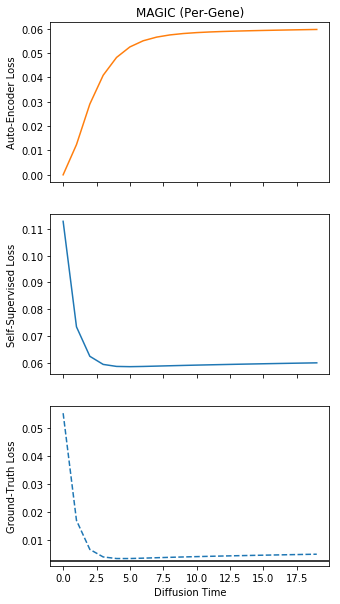

In [420]:
f, (ax0, ax1, ax2) = plt.subplots(3, 1, sharex=True, figsize=(5, 10))

ax0.plot(ae_losses.mean(axis = 1), color = 'C1')
ax0.set_title("MAGIC (Per-Gene)")
ax0.set_ylabel('Auto-Encoder Loss')

ax1.plot(ss_losses.mean(axis = 1))
ax1.set_ylabel('Self-Supervised Loss')
ax2.plot(gt_losses.mean(axis = 1), '--')
ax2.set_ylabel('Ground-Truth Loss')
ax2.set_xlabel('Diffusion Time')
ax2.axhline(best_gt_loss, color = 'black')

# Per-Gene Poisson

In [403]:
import magic
lazy_p=0.5

median_counts = np.median(x1.sum(axis=1)) / 2

X1 = np.sqrt(normalize_rows(x1, median_counts))
X2 = np.sqrt(normalize_rows(x2, median_counts))

magic_op = magic.MAGIC()
magic_op.fit(X1)

diff_op = np.array(magic_op.diff_op.todense())

diff_op = lazy_p * diff_op + (1 - lazy_p) * np.eye(diff_op.shape[0])

Running MAGIC on 1277 cells and 6883 genes.
Calculating graph and diffusion operator...
  Calculating PCA...
  Calculated PCA in 1.36 seconds.
  Calculating KNN search...
  Calculated KNN search in 0.27 seconds.
  Calculating affinities...
  Calculated affinities in 0.50 seconds.
Calculated graph and diffusion operator in 2.19 seconds.


In [421]:
denoised = x1.copy().astype(np.float)
best_denoised = x1.copy().astype(np.float)
max_t = 20

ss_losses = np.zeros((max_t, x1.shape[1]))
gt_losses = np.zeros((max_t, x1.shape[1]))
ae_losses = np.zeros((max_t, x1.shape[1]))

for t in range(max_t):
    denoised = diff_op.dot(denoised)
    ae_losses[t] = poisson_log_lik(denoised + 1e-3, x1, per_gene=True)
    ss_losses[t] = poisson_log_lik(denoised + 1e-3, x2, per_gene=True)
    gt_losses[t] = poisson_log_lik(denoised + 1e-3, mean, per_gene=True)
    new_best_idx = (np.argmin(ss_losses[:(t+1)], axis=0) == t)
    
    best_denoised[:, new_best_idx] = denoised[:, new_best_idx]

best_t = np.argmin(ss_losses, axis=0)

In [422]:
best_ae_loss = poisson_log_lik(best_denoised + 1e-3, x1)
best_ss_loss = poisson_log_lik(best_denoised + 1e-3, x2)
best_gt_loss = poisson_log_lik(best_denoised + 1e-3, mean)
np.isclose(best_gt_loss, gt_losses[best_t, np.arange(len(best_t))].mean())

True

In [423]:
np.min(gt_losses.mean(axis = 1)), best_gt_loss

(0.12290468410827969, 0.12035262483168338)

In [427]:
print("Best possible: ", poisson_log_lik(mean + 1e-3, mean))

Best possible:  0.10370534


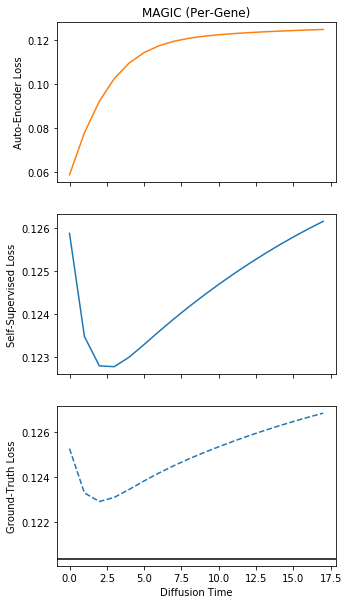

In [425]:
f, (ax0, ax1, ax2) = plt.subplots(3, 1, sharex=True, figsize=(5, 10))

ax0.plot(ae_losses[2:].mean(axis = 1), color = 'C1')
ax0.set_title("MAGIC (Per-Gene)")
ax0.set_ylabel('Auto-Encoder Loss')

ax1.plot(ss_losses[2:].mean(axis = 1))
ax1.set_ylabel('Self-Supervised Loss')
ax2.plot(gt_losses[2:].mean(axis = 1), '--')
ax2.set_ylabel('Ground-Truth Loss')
ax2.set_xlabel('Diffusion Time')
ax2.axhline(best_gt_loss, color = 'black')

(array([  58.,  381., 1281.,  923.,  614.,  380.,  268.,  192.,  147.,
        2639.]),
 array([ 0. ,  1.9,  3.8,  5.7,  7.6,  9.5, 11.4, 13.3, 15.2, 17.1, 19. ]),
 <a list of 10 Patch objects>)

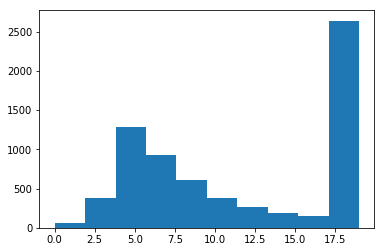

In [428]:
plt.hist(best_t)

# Poisson Matrix Factorization

In [226]:
from scipy.sparse import issparse
def cor(X, Y):
    if issparse(X):
        X = np.array(X.todense())
    if issparse(Y):
        Y = np.array(Y.todense())
    return np.corrcoef(X.ravel(), Y.ravel())[0, 1]

In [227]:
print("Original correlation: ", cor(hca_down.X.sqrt(), hca.X.sqrt()))

Original correlation:  0.7802032108454697


In [228]:
print("Denoised correlation: ", cor(np.sqrt(denoised_hca.X), hca.X.sqrt()))

NameError: name 'denoised_hca' is not defined

In [ ]:
print("Denoised correlation: ", cor(np.sqrt(denoised_hca_pca.X), hca.X.sqrt()))

In [ ]:
from util import poisson_expected_sqrt
expected_sqrt = poisson_expected_sqrt(np.array(hca.X.todense())/np.array(hca.X.todense()).sum(axis = 1, keepdims = True)*2000, 30)

# Simulation

In [162]:
import pickle
with open('/Users/josh/src/noise2self-single-cell/data/sim/dataset_0.pickle', 'rb') as fp:
    exp, class_labels, programs, lib_size, umis_X, umis_Y = pickle.load(fp)

In [163]:
true_means = np.exp(exp.dot(programs))

In [164]:
model = LowRank()
best_rank, rank_range, losses = model.sweep(umis_X, umis_Y, 30)

Optimal rank: 3


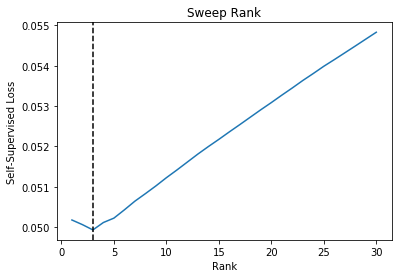

In [165]:
plt.plot(rank_range, losses)
plt.xlabel("Rank")
plt.ylabel("Self-Supervised Loss")
plt.title("Sweep Rank")
plt.axvline(best_rank, color="k", linestyle="--")

denoised = model.fit_transform(umis_X, umis_Y)

In [148]:
umis_X = paul.X

In [159]:
from sklearn.utils.extmath import randomized_svd

U, S, V = randomized_svd(np.sqrt(umis_X), 9)

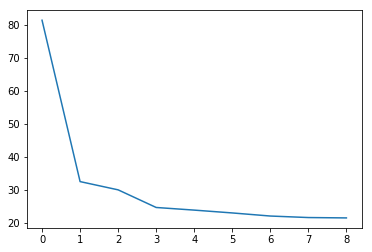

In [161]:
plt.plot(S)

(0, 1)

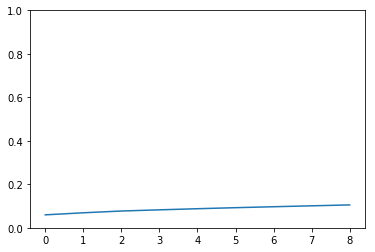

In [160]:
plt.plot((S*S).cumsum()/umis_X.sum())
plt.ylim(0,1)

In [137]:
denoised_sqrt = U.dot(np.diag(S)).dot(V)

In [139]:
denoised_sqrt = np.maximum(denoised_sqrt, 0)

In [133]:
correlation(denoised_sqrt.ravel(), np.sqrt(true_means).ravel())

ValueError: operands could not be broadcast together with shapes (26062511,) (2097152,) 

In [140]:
(denoised_sqrt*denoised_sqrt).sum(1)

array([2478.45  , 5567.8955, 4926.566 , ..., 3890.741 , 3409.2192,
       8071.7227], dtype=float32)

In [138]:
(denoised_sqrt*denoised_sqrt).sum(1)

array([2478.5254, 5568.3613, 4927.9585, ..., 3891.8545, 3409.6824,
       8071.7256], dtype=float32)

In [141]:
umis_X.sum(1)

array([ 4031.,  7741.,  7064., ...,  5689.,  5216., 10358.], dtype=float32)

In [55]:
from scipy.spatial.distance import correlation

In [73]:
(denoised*denoised).sum(), umis_X.sum()

(536.7738869945135, 111218)

In [56]:
correlation(np.sqrt(denoised).ravel(), np.sqrt(true_means).ravel())

0.37145616356605593

In [57]:
correlation(np.sqrt(umis_X).ravel(), np.sqrt(true_means).ravel())

0.8376143837983456

In [58]:
adata = sc.AnnData(X = umis_X)

In [ ]:
adata = 

# Stability of PC Regression

In [11]:
paul = sc.datasets.paul15()

... 100%

... storing 'paul15_clusters' as categorical


Optimal rank: 16


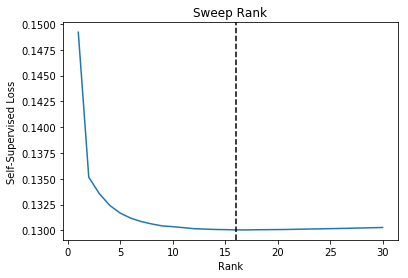

In [37]:
denoised_adata = n2s_low_rank(paul, regression=True)

In [ ]:
V = np.random.randn(500,5)
W = np.random.randn(5, 200)
L = (V.dot(W))
L = L/(np.max(L))*3

X1 = np.random.randn(V)
X2 = np.random.randn(W)

In [30]:
X = paul.X

X = X.astype(np.int)
np.random.seed(0)
X1 = np.random.binomial(X, 0.5)
X2 = X - X1

In [31]:
x = np.sqrt(denoised_adata.X)

In [36]:
rank_range = np.arange(1, 25, 2)
diff_from_opt = np.zeros(len(rank_range))
for i, r in enumerate(rank_range):
    model = LowRank(r, regression=True)
    y = model.fit_transform(X1, X2)
    diff = ((np.sqrt(y) - x)**2).mean()
    diff_from_opt[i] = diff
    print(r, ': ', diff)

1 :  0.02056164118959706
3 :  0.004906760324514881
5 :  0.0027534155659403267
7 :  0.0017187939439523943
9 :  0.001070357292043151
11 :  0.0006869342945542818
13 :  0.0003826122756931465
15 :  0.00018943817572063054
17 :  0.0002420149088303624
19 :  0.00037286476600429703
21 :  0.0005304636046424481
23 :  0.0006268238246982786


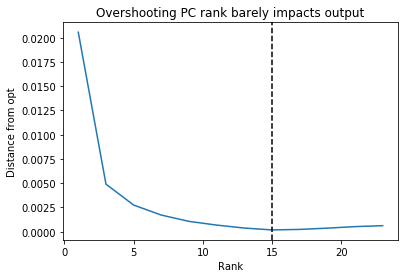

In [46]:
plt.plot(rank_range, diff_from_opt)
plt.xlabel("Rank")
plt.ylabel("Distance from opt")
plt.title("Overshooting PC rank barely impacts output")
plt.axvline(rank_range[np.argmin(diff_from_opt)], color='k', linestyle='--')

# Coefficients 

Given a matrix X which we write as $U S V$ and approximate as $U_r S_r V_r$, we may consider the PC regression to $Y$. That is,
we try to predict $Y$ from the feature matrix $X V_r^t S_r^{-1}= U_r$.

The regression map $W: \mathbb{R}^r \rightarrow \mathbb{R}^n$ is given by 

$W = U_r^t Y,$

since the feature matrix is orthogonal.

The weights for the $k^{th}$ PC are given by the $k^{th}$ row of that matrix. In particular, they do not depend on the choice of rank $r > k$.

(Note: there are two ways to view this. We may project the data $X$ orthogonally into PC space (in which case higher PCs will have low weight), or we may take it's coordinates in PC space (in which case all PCs will have equal weight). We choose the latter, since it shows that for the PCs with noisy values very little gets used. This is equivalent to dividing by $S_r$ after projection, which just shifts that term from $W$ over to the feature matrix.)

In [93]:
from scipy.sparse import issparse

X = paul.X
#X = hca_down.X

if issparse(X):
    X = np.array(X.todense())

X = X.astype(np.int)

np.random.seed(0)
X1 = np.random.binomial(X, 0.5)
X2 = X - X1

X1 = np.sqrt(X1)
X2 = np.sqrt(X2)

In [94]:
from sklearn.utils.extmath import randomized_svd

U, Sigma, VT = randomized_svd(X1, n_components=100, random_state=42)

In [95]:
W_pcr = U.T.dot(X2)
weight_norm_pcr = (W_pcr*W_pcr).sum(axis = 1)

W_pca = U.T.dot(X1)
weight_norm_pca = (W_pca*W_pca).sum(axis = 1)

The total norm of such coefficients is 1 if we use $X$ to regress $X$. When we are predicting $Y$, then the 
coefficients may drop off.

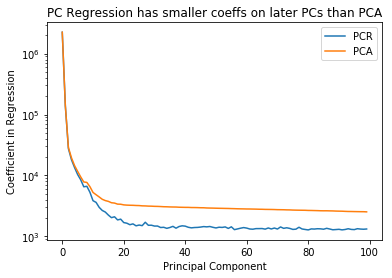

In [96]:
plt.plot(weight_norm_pcr, label = "PCR")
plt.plot(weight_norm_pca, label = "PCA")
plt.title("PC Regression has smaller coeffs on later PCs than PCA")
plt.xlabel("Principal Component")
plt.ylabel("Coefficient in Regression")
plt.yscale("log")
plt.legend()